# Deep Learning
## Practice Projects
# P2: Multi-Label Classification

## Step 0. Style and Libraries

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                  

In [2]:
hide_code = ''
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

Using TensorFlow backend.


## Step 1. Load and Explore the Data
Run the following cell to download the dataset.

In [3]:
hide_code
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/" + img_path, target_size=(32, 32))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background']
targets = data['label'].as_matrix()
tensors = data_to_tensor(files);

100%|██████████| 1650/1650 [00:23<00:00, 71.29it/s]


In [4]:
hide_code
# Print the shape 
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


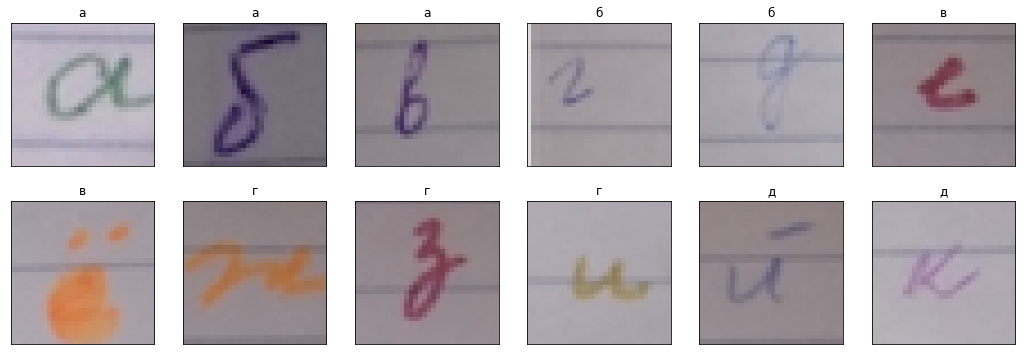

In [6]:
hide_code
# Read from files and display images using OpenCV
def display_images(img_path, ax):
    img = cv2.imread("data/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(18, 6))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[], title=letters[i*22])
    display_images(files[i*50], ax)

## Step 2. Save and Load the Data¶
The data tensors can be saved in the appropriate format of files .h5.

In [7]:
hide_code
# Create the tensor file
with h5py.File('LetterColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.create_dataset('backgrounds', data = backgrounds)
    f.close()

In [13]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [14]:
hide_code
# Create tensors and targets
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)


## Step 3. Implement Preprocess Functions
### Normalize and Gray Scale
In the cell below, normalize the image tensors, and return them as a normalized Numpy array.

In [15]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

Label:  в


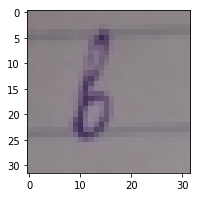

In [17]:
hide_code
# Read and display a tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(tensors[100]);

Create tensors of grayscaled images and display their shape.

In [18]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (1650, 32, 32)


Label:  в


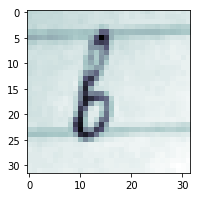

In [19]:
hide_code
# Read and display a grayscaled tensor using Matplotlib
print('Label: ', letters[100])
plt.figure(figsize=(3,3))
plt.imshow(gray_tensors[100], cmap=cm.bone);

### One-hot encode
Now we'll implement the one-hot encoding function to_categorical.

In [20]:
hide_code
# Print the target unique values
print(set(targets))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


In [21]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(1650, 33)

### Split
Apply the function train_test_split and split the data into training and testing sets. Set up the size of the testing set - 20%.

In [24]:
hide_code
# Split the data
x_train, x_test, y_train, y_test = train_test_split(tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

Let's pring the shape of these data sets.

In [25]:
hide_code
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (1320, 32, 32, 3)
Training target's shape (1320, 33)
Testing tensor's shape: (330, 32, 32, 3)
Testing target's shape (330, 33)


In [26]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, cat_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)

In [27]:
hide_code
# Reshape the grayscaled data
x_train2, x_test2 = x_train2.reshape(-1, 32, 32, 1), x_test2.reshape(-1, 32, 32, 1)

In [28]:
hide_code
# Print the shape
print ("Training grayscaled tensor's shape:", x_train2.shape)
print ("Training grayscaled target's shape", y_train2.shape)
print ("Testing grayscaled tensor's shape:", x_test2.shape)
print ("Testing grayscaled target's shape", y_test2.shape)

Training grayscaled tensor's shape: (1320, 32, 32, 1)
Training grayscaled target's shape (1320, 33)
Testing grayscaled tensor's shape: (330, 32, 32, 1)
Testing grayscaled target's shape (330, 33)


## Step 4. Create a One-Label Classification Model
### Color Images
Define a model architecture and compile the model for color images.

In [36]:
hide_code
def model():
    model = Sequential()
    # TODO: Define a model architecture

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D()) 
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))    

    model.add(Dense(33))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

model = model()

In [37]:
hide_code
# train the model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpointer])

Train on 1320 samples, validate on 330 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 3.49699, saving model to weights.best.model.hdf5
7s - loss: 3.5055 - acc: 0.0348 - val_loss: 3.4970 - val_acc: 0.0455
Epoch 2/100
Epoch 00001: val_loss did not improve
6s - loss: 3.4907 - acc: 0.0394 - val_loss: 3.4977 - val_acc: 0.0182
Epoch 3/100
Epoch 00002: val_loss improved from 3.49699 to 3.49533, saving model to weights.best.model.hdf5
6s - loss: 3.4971 - acc: 0.0318 - val_loss: 3.4953 - val_acc: 0.0333
Epoch 4/100
Epoch 00003: val_loss improved from 3.49533 to 3.47249, saving model to weights.best.model.hdf5
6s - loss: 3.4721 - acc: 0.0402 - val_loss: 3.4725 - val_acc: 0.0455
Epoch 5/100
Epoch 00004: val_loss improved from 3.47249 to 3.45549, saving model to weights.best.model.hdf5
6s - loss: 3.4758 - acc: 0.0356 - val_loss: 3.4555 - val_acc: 0.0333
Epoch 6/100
Epoch 00005: val_loss did not improve
6s - loss: 3.4531 - acc: 0.0470 - val_loss: 3.4566 - val_acc: 0.0333
Epoch 7/100

Epoch 00064: val_loss did not improve
6s - loss: 3.2013 - acc: 0.0902 - val_loss: 3.4994 - val_acc: 0.0576
Epoch 66/100
Epoch 00065: val_loss did not improve
5s - loss: 3.1872 - acc: 0.0909 - val_loss: 3.4940 - val_acc: 0.0576
Epoch 67/100
Epoch 00066: val_loss did not improve
6s - loss: 3.1733 - acc: 0.0879 - val_loss: 3.6774 - val_acc: 0.0606
Epoch 68/100
Epoch 00067: val_loss did not improve
5s - loss: 3.1908 - acc: 0.0909 - val_loss: 3.5875 - val_acc: 0.0576
Epoch 69/100
Epoch 00068: val_loss did not improve
5s - loss: 3.1792 - acc: 0.1015 - val_loss: 3.6204 - val_acc: 0.0636
Epoch 70/100
Epoch 00069: val_loss did not improve
6s - loss: 3.1765 - acc: 0.1068 - val_loss: 3.3975 - val_acc: 0.0727
Epoch 71/100
Epoch 00070: val_loss did not improve
5s - loss: 3.1674 - acc: 0.0970 - val_loss: 3.4714 - val_acc: 0.0636
Epoch 72/100
Epoch 00071: val_loss did not improve
6s - loss: 3.1650 - acc: 0.0788 - val_loss: 3.4098 - val_acc: 0.0879
Epoch 73/100
Epoch 00072: val_loss did not improve
5s

We should have an accuracy greater than 3%

In [38]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

320/330 [============================>.] - ETA: 0s

[3.3929212989229143, 0.072727272727272724]

Apply the ImageDataGenerator() function.

In [39]:
hide_code
steps, epochs = 1000, 5
data_generator = ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rotation_range=20)

generator = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                        steps_per_epoch = steps, epochs = epochs,
                                        validation_data = (x_test, y_test), 
                                        callbacks=[checkpointer], verbose=2)

Epoch 1/5
Epoch 00000: val_loss did not improve
280s - loss: 3.1527 - acc: 0.1002 - val_loss: 3.4413 - val_acc: 0.0667
Epoch 2/5
Epoch 00001: val_loss did not improve
276s - loss: 2.9898 - acc: 0.1234 - val_loss: 3.8741 - val_acc: 0.0788
Epoch 3/5
Epoch 00002: val_loss did not improve
276s - loss: 2.8761 - acc: 0.1392 - val_loss: 3.8046 - val_acc: 0.0727
Epoch 4/5
Epoch 00003: val_loss did not improve
302s - loss: 2.8007 - acc: 0.1497 - val_loss: 4.2373 - val_acc: 0.0667
Epoch 5/5
Epoch 00004: val_loss did not improve
317s - loss: 2.7512 - acc: 0.1575 - val_loss: 4.2089 - val_acc: 0.0515


In [40]:
hide_code
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

330/330 [==============================] - 0s     


[3.3929212989229143, 0.072727272727272724]

Let's compare the results with classifying algorithms.

In [41]:
hide_code
# Fit the classifier and get the accuracy score
y_train_c = np.array([np.argmax(y) for y in y_train])
y_test_c = np.array([np.argmax(y) for y in y_test])
clf = GradientBoostingClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.11212121212121212

In [42]:
hide_code
# Fit the classifier and get the accuracy score
clf2 = RandomForestClassifier().fit(x_train.reshape(-1, 32*32*3), y_train_c)
clf2.score(x_test.reshape(-1, 32*32*3), y_test_c)

0.10606060606060606

### Grayscaled Images

## Step 5. Create a Multi-Label Classification Model
### Color Images

### Grayscaled Images